In [1]:
import pandas as pd

import re
import sys

from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import accuracy_score
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

import pickle
# from ngram_config import ngram_creator

In [2]:
df = pd.read_csv('irish_names.csv')

In [3]:
model = make_pipeline(CountVectorizer(),MultinomialNB())

In [5]:
# for n in 3-5:
#     get ngrams of length n
#     stratify the data
#         train the model
        

In [147]:
def ngram_creator(term_list, n=3):
    """
    Takes two arguments: a list of words to break into ngrams and the length of the ngram

    Inputs:
        term_list: [list] terms to break into intraword ngrams (example: df['names'])
        n: [int] desired length of ngrams
    
    Outputs:
        ngrams of individual words: e.g., bigrams for 'dog' = ['do','og']
        gram_string_list: list where each element is the set of n-grams for each original record. Use in CountVectorizer
    """

    gram_string_list = []
    gram_length = n

    for i in term_list:
        i = str(i)
        i = re.sub('[^A-Za-z0-9]+', '', i) # Remove any punctuation, spaces, and special characters
        i = i.lower()
        i = "^"+i+"$"  # Add initial and terminal clusters
        word_grams = []
        gram_string = ""
        for j in range(gram_length,100):
            gram = i[j-gram_length:j]
            if len(gram) == gram_length:  # only keep ngrams of the correct length
                word_grams.append(gram)
                gram_string = gram_string + gram + " "
        gram_string = gram_string[:-1]  # Cut that last space off the end there
        gram_string_list.append(gram_string)  # Append the ngrams for the current name as a space-separated string
    
    return gram_string_list

In [11]:
def evaluate_model(y_test, predicted_labels, predicted_probs, fold_no):
    """
    Docstring here
    
    Input: 
    
    """

    # I'm using the F2 score because I want to maximize recall (minimize false negatives)
    # I say that because I want to capture as many Irish names as possible,
    # even if that means saying that others' names are more Irish than they really are.

    # f1 = f1_score(y_test, predicted_labels)
    f2 = fbeta_score(y_test, predicted_labels, average='binary', beta=2)

    cmatrix = confusion_matrix(y_test, predicted_labels)
    tn, fp, fn, tp = confusion_matrix(y_test, predicted_labels).ravel()

    FNR = fn/(fn+tp)

    pred_prob_results = pd.DataFrame(predicted_probs, columns=['irish_prob', 'not_irish_prob'])
    # pred_prob_results['test_index'] = test_index

    fold_summary = {'f2_score':f2
                    ,'confusion_matrix':{'tn':tn, 'fp':fp, 'fn':fn, 'tp':tp}
                    ,'predicted_probabilities':pred_prob_results
                    }

    return fold_summary

In [12]:
def train_model(train, test, fold_no, n, model_type, X='ngrams', y='irish_flag'):

    """
    Docstring here
    """

    fold_summaries = {}

    X_train = train[X] #.values
    y_train = train[y]

    X_test = test[X].values
    y_test = test[y]

    model.fit(X_train, y_train)
    predicted_labels = model.predict(X_test)
    predicted_probs = model.predict_proba(X_test)  # Return predicted probabilities for X_test data

    y_score = model.predict_proba(X_test)[:,1]  # What does this do?

    # Evaluate Models, Output Model Summary
    fold_summary = evaluate_model(y_test, predicted_labels, predicted_probs, fold_no=fold_no)
    
    # Aggregate Model Summaries
    fold_summaries[f'fold_no_{fold_no}'] = fold_summary

    # This just needs to return 

    return fold_summaries

In [58]:
def summarize_model(df, target, model_type, n):
    """
    This function trains a model on each of the stratified folds and returns
    a summary of the results.

    Input:
        df: (dataframe) Data to be used. Should have a column of ngrams and a target column
        target: (series) Target column of input df

    """

    skf = StratifiedKFold(n_splits=3)
    
    model_summary_dict = {}
    fold_no = 1

    for train_index, test_index in skf.split(df, target):
        train = df.loc[train_index,:]
        test = df.loc[test_index,:]
        model_summary = train_model(train, test, X='ngrams', y='irish_flag',
                                    n=n, fold_no=fold_no, model_type=model_type)
        # model_summary_dict[f"{n}_grams"] = {}
        model_summary_dict[f"fold_no_{fold_no}"] = model_summary
        fold_no += 1
    
    return model_summary_dict

In [148]:
n_length = [2,3,4,5]
name_types = ['full_name', 'given_name', 'surname']

all_model_results = {}


for names in name_types:
    all_model_results[f'model_type_{names}'] = {}

    for n in n_length:

        # n_gram_results = {}

        # print(n, " ", names)
        ngrams = ngram_creator(df[names], n)
        df_grams = pd.DataFrame(zip(ngrams,df['irish_flag']), columns=['ngrams','irish_flag'])

        target = df_grams.loc[:,'irish_flag']

        model_results = summarize_model(df_grams, target, model_type=names, n=n)

        all_model_results[f'model_type_{names}'][f'{n}_grams'] = model_results

        # n_gram_results[f'{n}_grams'] = model_results
    
    

In [149]:
model_type_f2_dict = {}
for names in name_types:
    
    n_gram_f2_dict = {}
    for n in n_length:
        

        f2_list = []
        for fold_no in range(1,4):
            
            f2_id = names+'_'+str(n)+'_'+str(fold_no)
            f2 = all_model_results[f'model_type_{names}'][f'{n}_grams'][f'fold_no_{fold_no}'][f'fold_no_{fold_no}']['f2_score']
            f2_list.append(f2)
        n_gram_f2_dict[f'{n}_gram'] = np.mean(f2_list)
    model_type_f2_dict[f'{names}'] = n_gram_f2_dict

print(model_type_f2_dict)

{'full_name': {'2_gram': 0.2597452734882378, '3_gram': 0.33402532500209015, '4_gram': 0.3675147611379495, '5_gram': 0.2820365560323039}, 'given_name': {'2_gram': 0.17592685092685093, '3_gram': 0.26852560560234484, '4_gram': 0.28083725476823757, '5_gram': 0.23661902129196669}, 'surname': {'2_gram': 0.23867408869089166, '3_gram': 0.3499838426118444, '4_gram': 0.3678225219555527, '5_gram': 0.35233217737418515}}


In [150]:
df_f2_it = (pd.json_normalize(model_type_f2_dict)
        .T
        .sort_values(by=0, ascending=False)
        .rename(columns={0:'f2_avg'}))
df_f2_it

,f2_avg
surname.4_gram,0.367823
full_name.4_gram,0.367515
surname.5_gram,0.352332
surname.3_gram,0.349984
full_name.3_gram,0.334025
full_name.5_gram,0.282037
given_name.4_gram,0.280837
given_name.3_gram,0.268526
full_name.2_gram,0.259745
surname.2_gram,0.238674


In [146]:
df_f2 = (pd.json_normalize(model_type_f2_dict)
        .T
        .sort_values(by=0, ascending=False)
        .rename(columns={0:'f2_avg'}))
df_f2

,f2_avg
full_name.3_gram,0.323789
surname.3_gram,0.308431
full_name.4_gram,0.296420
surname.4_gram,0.296222
full_name.2_gram,0.259745
surname.2_gram,0.238674
full_name.5_gram,0.237383
given_name.3_gram,0.225734
surname.5_gram,0.193760
given_name.2_gram,0.175927


In [151]:
murph = df_f2.reset_index().rename(columns={'index':'model_type.ngrams'})
murph_it = df_f2_it.reset_index().rename(columns={'index':'model_type.ngrams'})

In [152]:
murph['model_type'] = murph['model_type.ngrams'].str.split('.',expand=True).rename(columns={0:'model_type',1:'ngrams'}).iloc[:,0]
murph['ngrams'] = murph['model_type.ngrams'].str.split('.',expand=True).rename(columns={0:'model_type',1:'ngrams'}).iloc[:,1]

murph_it['model_type'] = murph_it['model_type.ngrams'].str.split('.',expand=True).rename(columns={0:'model_type',1:'ngrams'}).iloc[:,0]
murph_it['ngrams'] = murph_it['model_type.ngrams'].str.split('.',expand=True).rename(columns={0:'model_type',1:'ngrams'}).iloc[:,1]

In [153]:
murph['it_clusters'] = 'no_it_clusters'
murph_it['it_clusters'] = 'with_it_clusters'

In [160]:
murph_all = pd.concat([murph, murph_it])

# set categorical order
murph_all['ngrams'] = pd.Categorical(murph_all['ngrams'],
                                   categories=['2_gram', '3_gram', '4_gram', '5_gram'],
                                   ordered=True)

Text(0.5, 1.0, 'Best Model: Surname 4_grams with initial & terminal clusters')

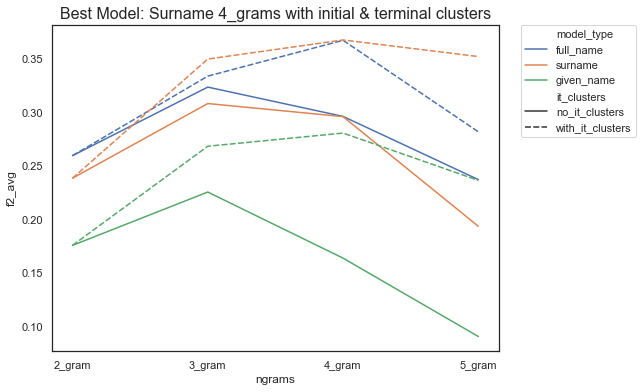

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("white")

ax = sns.lineplot(data=murph_all
            ,x='ngrams'
            ,y='f2_avg'
            ,hue='model_type'
            ,style='it_clusters'
            ,sort=True
            )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Best Model: Surname 4_grams with initial & terminal clusters', fontsize=16)

## That's a 13.6% improvement by adding initial and terminal clusters
Also interesting that it changed from the full_name model being better to the full name and surname models being basically equal.
I expected the surname model to be much more predictive than the full name model, but the only time that happened was surname vs. full_name 5-grams, and it wasn't the top performer.

In [ ]:
{full_name:                     # model_type
    {3_grams:                   # n
        {fold_1:                # fold_no
            {f2:###             # The evaluate function should create these
            ,confusion_matrix:###
            ,pred_probs:###
            }
        ,fold_2:
            {f2:###
            ,confusion_matrix:###
            ,pred_probs:###
            }
        }
    ,4_grams:
        {fold_1:
            {f2:###
            ,confusion_matrix:###
            ,pred_probs:###
            }
        ,fold_2:
            {f2:###
            ,confusion_matrix:###
            ,pred_probs:###
            }
        }
    }
,given_name:
    {3_grams:
        {fold_1:
            {f2:###
            ,confusion_matrix:###
            ,pred_probs:###
            }
        ,fold_2:
            {f2:###
            ,confusion_matrix:###
            ,pred_probs:###
            }
        }
    ,4_grams:
        {fold_1:
            {f2:###
            ,confusion_matrix:###
            ,pred_probs:###
            }
        ,fold_2:
            {f2:###
            ,confusion_matrix:###
            ,pred_probs:###
            }
        }
    }
}